# Collaborative Filtering
- 좀더 대량의 데이터를 가지고 협업 필터링을 구현해보겠습니다.
- 대량의 데이터를 사용할 경우 희소성(sparsity) 문제를 해결하는 것은 필요합니다.

In [81]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.utils import get_file
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from google_drive_downloader import GoogleDriveDownloader as gdd

np.set_printoptions(precision=3)

In [3]:
gdd.download_file_from_google_drive(file_id="1uPjBuhv96mJP9oFi-KNyVzNkSlS7U2xY", dest_path="./movies.csv")
movies_df = pd.read_csv("movies.csv", index_col=0)

gdd.download_file_from_google_drive(file_id="1hik_RSV0e5r_P3iYe4sK8B-eNWxmIWOa", dest_path="./genres.csv")
genres_df = pd.read_csv("genres.csv", index_col=0)

gdd.download_file_from_google_drive(file_id="15vsm-VWAC3Y-7jr7ROL_xy0ufkIfqSke", dest_path="./ratings.csv")
ratings_df = pd.read_csv("ratings.csv", index_col=0)

#id:title의 dictionary를 만듭니다.
id2title = dict(zip(movies_df["id"], movies_df["title"]))
ratings_df["title"] = ratings_df["movie_id"].map(id2title)

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.0\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## 데이터의 희소성(Sparsity)
- 데이터가 희소하다는 말은 MovieLens 데이터를 예로 들면 사용자와 아이템의 갯수에 비해 사용자와 아이템 간의 상호작용(평점을 매기는 행위)이 일어난 경우는 극히 드물어 사용자-아이템 행렬의 대부분의 값이 비어 있는 것을 말합니다.
- 데이터가 희소한 이유는 어떤 사용자도 수많은 영화들 중 일부만을 보며 영화를 보았다고 해도 평점을 남기는 경우는 흔하지 않기 때문입니다.

In [3]:
n_user = ratings_df["user_id"].nunique()
n_item = ratings_df["movie_id"].nunique()

print(f"density : {len(ratings_df)/(n_user*n_item)*100:>.2f}%")

density : 0.54%


- 사용자-아이템 행렬의 전체 칸 중 0.54%만이 값이 채워져 있음을 알 수 있습니다.

## 평점 갯수의 기준 정하기
- 평점을 준 사용자의 수가 매우 적은 영화 또는 평점을 매우 적게 남긴 사용자를 활용하면 분석에 왜곡이 발생할 수 있으므로 이를 방지하고 행렬의 밀집도(density)를 높이기 위해 평점 갯수에 기준을 정하고 기준 이하인 샘플을 제거합니다.

In [4]:
#사용자별 평점의 수를 구합니다.
n_rating_user = ratings_df["user_id"].value_counts()
#사용자별 평점의 수의 누적 합을 구하고 전체 평점의 수에 대한 비율로 나타냅니다.
cumsum_user = n_rating_user.cumsum()/len(ratings_df)

#사용자별 평점의 수와 그 비율을 합칩니다.
concat_user = pd.concat([n_rating_user, cumsum_user], axis=1)
concat_user.columns = ["n_rating", "cumsum"]

In [5]:
concat_user

,n_rating,cumsum
118205,9254,0.000463
8405,7515,0.000838
82418,5646,0.001121
121535,5520,0.001397
125794,5491,0.001671
...,...,...
59390,20,0.999996
23558,20,0.999997
34668,20,0.999998
80291,20,0.999999


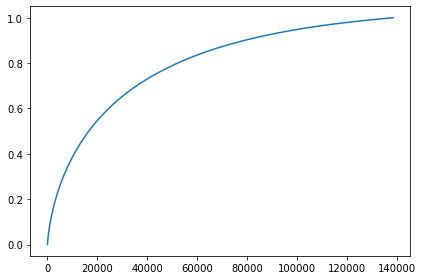

In [6]:
fig, ax = plt.subplots()

ax.plot(concat_user["cumsum"].reset_index(drop=True))

fig.tight_layout()

- 기울기가 점차 감소하는 위로 볼록한 증가 함수의 형태를 보입니다.
- 전체 평점의 수의 90%를 차지하는 평점 수 상위 사용자를 뽑겠습니다.

In [7]:
thrsd_user = concat_user[concat_user["cumsum"]<=0.9]["n_rating"].min()

In [8]:
thrsd_user

56

- 평점을 56개 이상 남긴 사용자가 전체 평점의 90%를 차지함을 알 수 있습니다.

In [9]:
over_thrsd_user = concat_user[concat_user["n_rating"]>=thrsd_user].index

In [10]:
#아이템별 평점의 수를 구합니다.
n_rating_item = ratings_df["movie_id"].value_counts()
#아이템별 평점의 수의 누적 합을 구하고 전체 평점의 수에 대한 비율로 나타냅니다.
cumsum_item = n_rating_item.cumsum()/len(ratings_df)

#아이템별 평점의 수와 그 비율을 합칩니다.
concat_item = pd.concat([n_rating_item, cumsum_item], axis=1)
concat_item.columns = ["n_rating", "cumsum"]

In [11]:
concat_item

,n_rating,cumsum
296,67310,0.003365
356,66172,0.006674
318,63366,0.009842
593,63299,0.013007
480,59715,0.015993
...,...,...
123607,1,1.000000
90823,1,1.000000
123609,1,1.000000
123613,1,1.000000


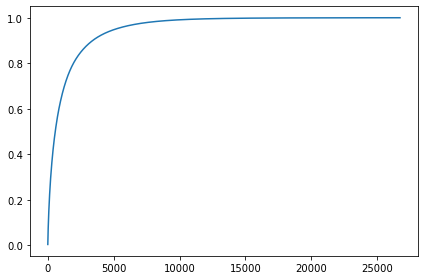

In [12]:
fig, ax = plt.subplots()

ax.plot(concat_item["cumsum"].reset_index(drop=True))

fig.tight_layout()

- 마찬가지로 기울기가 점차 감소하는 위로 볼록한 증가 함수의 형태를 보이지만 기울기가 좀 더 급격하게 감소합니다.
- 전체 평점의 수의 90%를 차지하는 평점 수 상위 영화를 뽑겠습니다.

In [13]:
thrsd_item = concat_item[concat_item["cumsum"]<=0.9]["n_rating"].min()

In [14]:
thrsd_item

879

- 평점이 879개 이상인 영화가 전체 평점의 90%를 차지함을 알 수 있습니다.

In [15]:
over_thrsd_item = concat_item[concat_item["n_rating"]>=thrsd_item].index

위에서 구한 사용자와 영화만을 남기고 ratings_df를 재구성합니다.

In [16]:
ratings_df_tr = ratings_df[(ratings_df["user_id"].isin(over_thrsd_user)) & ratings_df["movie_id"].isin(over_thrsd_item)]

In [17]:
ratings_df_tr

,user_id,movie_id,rating,rated_at,title
0,1,2,3.5,1112486027,Jumanji
1,1,29,3.5,1112484676,"City of Lost Children, The (Cité des enfants p..."
2,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys)
3,1,47,3.5,1112484727,Seven (a.k.a. Se7en)
4,1,50,3.5,1112484580,"Usual Suspects, The"
...,...,...,...,...,...
20000257,138493,68319,4.5,1260209720,X-Men Origins: Wolverine
20000258,138493,68954,4.5,1258126920,Up
20000259,138493,69526,4.5,1259865108,Transformers: Revenge of the Fallen
20000260,138493,69644,3.0,1260209457,Ice Age: Dawn of the Dinosaurs


In [18]:
print(f"샘플 수의 감소 : {len(ratings_df_tr)/len(ratings_df):.1%}")

샘플 수의 감소 : 80.4%


## User-Item Matrix 만들기

In [4]:
%%time
file = "ui_movielens.csv"
gdd.download_file_from_google_drive(file_id="1jawc0X5l5HERfIirnEnhBatQ9lL3sefB", dest_path=f"./{file}")
if os.path.exists(file):
    print("loading...")
    ui = pd.read_csv(file, index_col=0)
else:
    ui = pd.pivot_table(ratings_df_tr, index="user_id", columns="movie_id", values="rating")
    
    print("saving...")
    ui.to_csv(file)
print("completed!")

loading...
completed!
Wall time: 45.8 s


In [5]:
ui.sample(5)

,1,2,3,4,5,6,7,8,9,10,...,106920,108932,109374,109487,110102,111362,111759,112290,112556,112852
user_id,,,,,,,,,,,,,,,,,,,,,
14073,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50652,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40483,3.5,1.5,1.5,NaN,2.0,2.5,2.5,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
%%time
avg_rating = ui.mean().mean()

#사용자 편향을 계산합니다.
user_bias = ui.mean(axis=1) - avg_rating
#아이템 편향을 계산합니다.
item_bias = ui.mean(axis=0) - avg_rating

adj_ui = ui.sub(user_bias, axis=0).sub(item_bias, axis=1)

Wall time: 42.2 s


In [9]:
adj_ui

,1,2,3,4,5,6,7,8,9,10,...,106920,108932,109374,109487,110102,111362,111759,112290,112556,112852
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.357315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,3.670128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.749197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,2.334588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,3.379104,NaN,NaN,NaN,3.13425,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138486,4.027747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cosine Similarity를 이용한 Item Similarity Matrix 구하기

### numpy로 구현하기

In [15]:
#결측치를 0으로 채웁니다.
adj_ui = adj_ui.fillna(0)

norm_item = np.linalg.norm(adj_ui, axis=0, ord=2)

#matrix의 각 column을 normalization합니다.
adj_ui_norm = adj_ui.div(norm_item, axis=1)

#행렬곱으로 아이템에 대한 cosine similarity를 계산합니다.
cos_sim_item = np.dot(adj_ui_norm.T, adj_ui_norm)

titles = [id2title[int(i)] for i in adj_ui_norm.columns]

cos_sim_item_df = pd.DataFrame(cos_sim_item, index=titles, columns=titles)

In [29]:
cos_sim_item_df

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Her,The Lego Movie,"Grand Budapest Hotel, The",Interstellar,Captain America: The Winter Soldier,X-Men: Days of Future Past,Edge of Tomorrow,Boyhood,Gone Girl,Guardians of the Galaxy
Toy Story,1.000000,0.475866,0.313104,0.145894,0.307152,0.405799,0.316670,0.128454,0.176507,0.457965,...,0.123043,0.132020,0.127067,0.106763,0.117327,0.121307,0.119707,0.085146,0.103248,0.134326
Jumanji,0.475866,1.000000,0.303396,0.177265,0.328597,0.333055,0.290341,0.197598,0.178732,0.489666,...,0.101543,0.101325,0.098282,0.088183,0.097065,0.104330,0.097977,0.065562,0.085900,0.110369
Grumpier Old Men,0.313104,0.303396,1.000000,0.203054,0.441154,0.283953,0.380704,0.162822,0.266061,0.283258,...,0.031518,0.043235,0.036435,0.022882,0.037384,0.036882,0.034375,0.022198,0.030760,0.039789
Waiting to Exhale,0.145894,0.177265,0.203054,1.000000,0.233430,0.135256,0.225442,0.145640,0.128311,0.149685,...,0.015960,0.017911,0.019203,0.011516,0.017489,0.014419,0.018044,0.019707,0.018251,0.017189
Father of the Bride Part II,0.307152,0.328597,0.441154,0.233430,1.000000,0.248949,0.404654,0.191049,0.254268,0.281338,...,0.036662,0.044959,0.038083,0.029510,0.041224,0.038052,0.037281,0.025788,0.033832,0.043030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X-Men: Days of Future Past,0.121307,0.104330,0.036882,0.014419,0.038052,0.086638,0.035793,0.013949,0.025910,0.081039,...,0.376159,0.448587,0.388757,0.449928,0.663245,1.000000,0.616116,0.256703,0.418982,0.648766
Edge of Tomorrow,0.119707,0.097977,0.034375,0.018044,0.037281,0.102062,0.034371,0.011139,0.025725,0.083078,...,0.419539,0.434578,0.442688,0.530583,0.557419,0.616116,1.000000,0.308454,0.478296,0.617550
Boyhood,0.085146,0.065562,0.022198,0.019707,0.025788,0.076080,0.027795,0.011624,0.017176,0.047520,...,0.432769,0.277135,0.431468,0.372374,0.232558,0.256703,0.308454,1.000000,0.461521,0.318246
Gone Girl,0.103248,0.085900,0.030760,0.018251,0.033832,0.094313,0.031115,0.008982,0.021694,0.065574,...,0.443362,0.359528,0.473440,0.528914,0.373054,0.418982,0.478296,0.461521,1.000000,0.467075


### sklearn.metrics.pairwise.cosine_similarity 이용하기

In [ ]:
cos_sim_item = cosine_similarity(adj_ui.T)

cos_sim_item_df = pd.DataFrame(cos_sim_item, index=titles, columns=titles)

In [33]:
cos_sim_item_df

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Her,The Lego Movie,"Grand Budapest Hotel, The",Interstellar,Captain America: The Winter Soldier,X-Men: Days of Future Past,Edge of Tomorrow,Boyhood,Gone Girl,Guardians of the Galaxy
Toy Story,1.000000,0.475866,0.313104,0.145894,0.307152,0.405799,0.316670,0.128454,0.176507,0.457965,...,0.123043,0.132020,0.127067,0.106763,0.117327,0.121307,0.119707,0.085146,0.103248,0.134326
Jumanji,0.475866,1.000000,0.303396,0.177265,0.328597,0.333055,0.290341,0.197598,0.178732,0.489666,...,0.101543,0.101325,0.098282,0.088183,0.097065,0.104330,0.097977,0.065562,0.085900,0.110369
Grumpier Old Men,0.313104,0.303396,1.000000,0.203054,0.441154,0.283953,0.380704,0.162822,0.266061,0.283258,...,0.031518,0.043235,0.036435,0.022882,0.037384,0.036882,0.034375,0.022198,0.030760,0.039789
Waiting to Exhale,0.145894,0.177265,0.203054,1.000000,0.233430,0.135256,0.225442,0.145640,0.128311,0.149685,...,0.015960,0.017911,0.019203,0.011516,0.017489,0.014419,0.018044,0.019707,0.018251,0.017189
Father of the Bride Part II,0.307152,0.328597,0.441154,0.233430,1.000000,0.248949,0.404654,0.191049,0.254268,0.281338,...,0.036662,0.044959,0.038083,0.029510,0.041224,0.038052,0.037281,0.025788,0.033832,0.043030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X-Men: Days of Future Past,0.121307,0.104330,0.036882,0.014419,0.038052,0.086638,0.035793,0.013949,0.025910,0.081039,...,0.376159,0.448587,0.388757,0.449928,0.663245,1.000000,0.616116,0.256703,0.418982,0.648766
Edge of Tomorrow,0.119707,0.097977,0.034375,0.018044,0.037281,0.102062,0.034371,0.011139,0.025725,0.083078,...,0.419539,0.434578,0.442688,0.530583,0.557419,0.616116,1.000000,0.308454,0.478296,0.617550
Boyhood,0.085146,0.065562,0.022198,0.019707,0.025788,0.076080,0.027795,0.011624,0.017176,0.047520,...,0.432769,0.277135,0.431468,0.372374,0.232558,0.256703,0.308454,1.000000,0.461521,0.318246
Gone Girl,0.103248,0.085900,0.030760,0.018251,0.033832,0.094313,0.031115,0.008982,0.021694,0.065574,...,0.443362,0.359528,0.473440,0.528914,0.373054,0.418982,0.478296,0.461521,1.000000,0.467075


In [34]:
#토이 스토리와 유사한 영화
cos_sim_item_df.loc["Toy Story"].sort_values(ascending=False).iloc[1:11]

Forrest Gump                                                               0.630181
Star Wars: Episode IV - A New Hope                                         0.628852
Jurassic Park                                                              0.626524
Toy Story 2                                                                0.624472
Back to the Future                                                         0.623630
Aladdin                                                                    0.621177
Lion King, The                                                             0.614778
Star Wars: Episode VI - Return of the Jedi                                 0.614438
Star Wars: Episode V - The Empire Strikes Back                             0.600851
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark)    0.596957
Name: Toy Story, dtype: float64

In [35]:
#쏘우와 유사한 영화
cos_sim_item_df.loc["Saw"].sort_values(ascending=False).iloc[1:11]

Saw II                  0.613026
Saw III                 0.482369
The Butterfly Effect    0.463153
Ring, The               0.447622
Dawn of the Dead        0.427478
Sin City                0.411080
28 Days Later           0.403311
Identity                0.402746
Village, The            0.390142
Kill Bill: Vol. 1       0.387183
Name: Saw, dtype: float64

In [36]:
#레고 무비와 유사한 영화
cos_sim_item_df.loc["The Lego Movie"].sort_values(ascending=False).iloc[1:11]

Guardians of the Galaxy                0.506256
Captain America: The Winter Soldier    0.463190
X-Men: Days of Future Past             0.448587
Wreck-It Ralph                         0.446306
Frozen                                 0.437885
Edge of Tomorrow                       0.434578
Gravity                                0.416407
Grand Budapest Hotel, The              0.415949
Pacific Rim                            0.407444
Hunger Games: Catching Fire, The       0.396589
Name: The Lego Movie, dtype: float64

## Euclidean Distance를 이용한 Item Similarity Matrix 구하기

### numpy로 구현하기
$$
euc\_dist(\vec{X}, \vec{Y}) = \sqrt{\sum(X_i - Y_i)^2} = \sqrt{\sum(X_i^2 + Y_i^2 - 2X_iY_i)} = \sqrt{\sum X_i^2 + \sum Y_i^2 - 2\vec{X} \cdot \vec{Y}}
$$
$$
euc\_sim(\vec{X},\vec{Y}) = \frac{1}{1 + euc\_dist(\vec{X}, \vec{Y})}
$$

In [37]:
adj_ui

,1,2,3,4,5,6,7,8,9,10,...,106920,108932,109374,109487,110102,111362,111759,112290,112556,112852
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,3.357315,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,3.670128,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.749197,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,2.334588,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000000,3.379104,0.0,0.0,0.0,3.13425,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138486,4.027747,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138487,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138490,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
square = np.array(np.sum(adj_ui**2, axis=0))

In [85]:
square

array([411538.527, 223076.941, 100692.842, ...,   8277.058,  12856.349,
        18137.478])

In [86]:
dot = np.dot(adj_ui.T, adj_ui)

In [87]:
dot

array([[411538.527, 144184.076,  63737.203, ...,   4969.419,   7510.101,
         11605.238],
       [144184.076, 223076.941,  45471.134, ...,   2817.205,   4600.22 ,
          7020.441],
       [ 63737.203,  45471.134, 100692.842, ...,    640.841,   1106.735,
          1700.403],
       ...,
       [  4969.419,   2817.205,    640.841, ...,   8277.058,   4760.888,
          3899.327],
       [  7510.101,   4600.22 ,   1106.735, ...,   4760.888,  12856.349,
          7132.367],
       [ 11605.238,   7020.441,   1700.403, ...,   3899.327,   7132.367,
         18137.478]])

In [91]:
euc_sim_item = 1 / (1 + np.sqrt(np.add.outer(square, square) - 2*dot))
np.fill_diagonal(euc_sim_item, 1)

titles = [id2title[int(i)] for i in adj_ui_norm.columns]

euc_sim_item_df = pd.DataFrame(euc_sim_item, index=titles, columns=titles)

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [92]:
euc_sim_item_df

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Her,The Lego Movie,"Grand Budapest Hotel, The",Interstellar,Captain America: The Winter Soldier,X-Men: Days of Future Past,Edge of Tomorrow,Boyhood,Gone Girl,Guardians of the Galaxy
Toy Story,1.000000,0.001697,0.001610,0.001561,0.001609,0.001610,0.001609,0.001566,0.001571,0.001650,...,0.001563,0.001569,0.001562,0.001560,0.001565,0.001565,0.001564,0.001560,0.001560,0.001566
Jumanji,0.001697,1.000000,0.002068,0.002109,0.002116,0.001849,0.002040,0.002151,0.002100,0.002038,...,0.002091,0.002105,0.002081,0.002091,0.002103,0.002102,0.002095,0.002100,0.002096,0.002094
Grumpier Old Men,0.001610,0.002068,1.000000,0.003033,0.003016,0.002075,0.002791,0.003108,0.003099,0.001965,...,0.002935,0.003009,0.002908,0.002956,0.003001,0.002980,0.002964,0.003038,0.002988,0.002935
Waiting to Exhale,0.001561,0.002109,0.003033,1.000000,0.003159,0.002119,0.003010,0.005094,0.004239,0.001995,...,0.004639,0.004923,0.004512,0.004757,0.004910,0.004808,0.004756,0.005165,0.004880,0.004602
Father of the Bride Part II,0.001609,0.002116,0.003016,0.003159,1.000000,0.002047,0.002887,0.003229,0.003155,0.001976,...,0.003018,0.003094,0.002984,0.003042,0.003087,0.003062,0.003047,0.003127,0.003073,0.003015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X-Men: Days of Future Past,0.001565,0.002102,0.002980,0.004808,0.003062,0.002135,0.002920,0.005901,0.004605,0.001992,...,0.007091,0.008259,0.006836,0.007881,0.010494,1.000000,0.009367,0.007668,0.007940,0.009255
Edge of Tomorrow,0.001564,0.002095,0.002964,0.004756,0.003047,0.002140,0.002906,0.005783,0.004554,0.001991,...,0.007230,0.007980,0.007052,0.008368,0.008969,0.009367,1.000000,0.007728,0.008199,0.008761
Boyhood,0.001560,0.002100,0.003038,0.005165,0.003127,0.002148,0.002979,0.006579,0.004882,0.001994,...,0.008036,0.008146,0.007545,0.008143,0.007873,0.007668,0.007728,1.000000,0.009195,0.007276
Gone Girl,0.001560,0.002096,0.002988,0.004880,0.003073,0.002143,0.002928,0.006006,0.004651,0.001989,...,0.007623,0.007847,0.007443,0.008672,0.007900,0.007940,0.008199,0.009195,1.000000,0.007672


### sklearn.metrics.pairwise.euclidean_distances 이용하기

In [82]:
euc_sim_item = 1 / (1 + euclidean_distances(adj_ui.T))

euc_sim_item_df = pd.DataFrame(euc_sim_item, index=titles, columns=titles)

In [83]:
euc_sim_item_df

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Her,The Lego Movie,"Grand Budapest Hotel, The",Interstellar,Captain America: The Winter Soldier,X-Men: Days of Future Past,Edge of Tomorrow,Boyhood,Gone Girl,Guardians of the Galaxy
Toy Story,1.000000,0.001697,0.001610,0.001561,0.001609,0.001610,0.001609,0.001566,0.001571,0.001650,...,0.001563,0.001569,0.001562,0.001560,0.001565,0.001565,0.001564,0.001560,0.001560,0.001566
Jumanji,0.001697,1.000000,0.002068,0.002109,0.002116,0.001849,0.002040,0.002151,0.002100,0.002038,...,0.002091,0.002105,0.002081,0.002091,0.002103,0.002102,0.002095,0.002100,0.002096,0.002094
Grumpier Old Men,0.001610,0.002068,1.000000,0.003033,0.003016,0.002075,0.002791,0.003108,0.003099,0.001965,...,0.002935,0.003009,0.002908,0.002956,0.003001,0.002980,0.002964,0.003038,0.002988,0.002935
Waiting to Exhale,0.001561,0.002109,0.003033,1.000000,0.003159,0.002119,0.003010,0.005094,0.004239,0.001995,...,0.004639,0.004923,0.004512,0.004757,0.004910,0.004808,0.004756,0.005165,0.004880,0.004602
Father of the Bride Part II,0.001609,0.002116,0.003016,0.003159,1.000000,0.002047,0.002887,0.003229,0.003155,0.001976,...,0.003018,0.003094,0.002984,0.003042,0.003087,0.003062,0.003047,0.003127,0.003073,0.003015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X-Men: Days of Future Past,0.001565,0.002102,0.002980,0.004808,0.003062,0.002135,0.002920,0.005901,0.004605,0.001992,...,0.007091,0.008259,0.006836,0.007881,0.010494,1.000000,0.009367,0.007668,0.007940,0.009255
Edge of Tomorrow,0.001564,0.002095,0.002964,0.004756,0.003047,0.002140,0.002906,0.005783,0.004554,0.001991,...,0.007230,0.007980,0.007052,0.008368,0.008969,0.009367,1.000000,0.007728,0.008199,0.008761
Boyhood,0.001560,0.002100,0.003038,0.005165,0.003127,0.002148,0.002979,0.006579,0.004882,0.001994,...,0.008036,0.008146,0.007545,0.008143,0.007873,0.007668,0.007728,1.000000,0.009195,0.007276
Gone Girl,0.001560,0.002096,0.002988,0.004880,0.003073,0.002143,0.002928,0.006006,0.004651,0.001989,...,0.007623,0.007847,0.007443,0.008672,0.007900,0.007940,0.008199,0.009195,1.000000,0.007672


In [77]:
#토이 스토리와 유사한 영화
euc_sim_item_df.loc["Toy Story"].sort_values(ascending=False).iloc[1:11]

Aladdin                                0.001862
Lion King, The                         0.001844
Bug's Life, A                          0.001834
Monsters, Inc.                         0.001813
Back to the Future                     0.001812
Willy Wonka & the Chocolate Factory    0.001798
Groundhog Day                          0.001794
Beauty and the Beast                   0.001790
Shrek                                  0.001788
Men in Black (a.k.a. MIB)              0.001786
Name: Toy Story, dtype: float64

In [78]:
#쏘우와 유사한 영화
euc_sim_item_df.loc["Saw"].sort_values(ascending=False).iloc[1:11]

Saw II                          0.005026
Saw III                         0.004540
Saw IV                          0.004304
Hostel                          0.004238
Hills Have Eyes, The            0.004149
Grudge, The                     0.004137
Descent, The                    0.004126
Silent Hill                     0.004125
Skeleton Key, The               0.004124
Texas Chainsaw Massacre, The    0.004112
Name: Saw, dtype: float64

In [79]:
#레고 무비와 유사한 영화
euc_sim_item_df.loc["The Lego Movie"].sort_values(ascending=False).iloc[1:11]

Thor: The Dark World                   0.008721
Captain America: The Winter Soldier    0.008663
Frozen                                 0.008539
Pacific Rim                            0.008453
X-Men: Days of Future Past             0.008259
Elysium                                0.008167
Boyhood                                0.008146
Brave                                  0.008139
Prisoners                              0.008116
World War Z                            0.008113
Name: The Lego Movie, dtype: float64